**About the dataset:**
The 'Shoe Classification Dataset' contains images of shoes of three different brands, namely Nike, Adidas and Converse. To  be more precise, the train set contains 711 images and the test contains 114 images. The aim of the project is to develop a Convolutional Neural Network that can classify the test images into the three classes. 

This notebook attempts to build a CNN from scratch and check the performace and then try using Transfer Learning to build an even better CNN model.

Let's import the necessary libraries:

In [1]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

Since we are building a CNN model, it'll invlove a lot of vector and matrix multiplication operations, and using the CPU would take hours to complete these operations. So, let's use the GPUs:

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_directory = '../input/nike-adidas-and-converse-imaged/train'
test_directory = '../input/nike-adidas-and-converse-imaged/test'

Before loading the dataset, we need to decide and define how we want to transform the dataset, why do you ask?

The training images are all of the same size, but we need to take into account positional invariance, rotational invariance and scale invariance as well. The CNN learns the patterns of all the classes irresepective of the the three mentioned invariances, and then make more accurate predictions than otherwise. 

So let's compose a series of transforms for train set and another set for test set (train set transform just resizes the image, converts it to a tensor and normalizes the tensor values).

Define the dataset transformations:
1. Random Resized Crop: This randomly crops the image to the specified size.
2. Random Horizontal Flip: This flips 50% of the images horizontally.
3. Random Vertical Flip: This flips 50% of the images vertically.
4. Random Rotation: This rotates the images between the range of -45 degrees to 45 degrees.
5. To Tensor: Convert the images into tensors.
6. Normalize: This normalizes all the values in the tensor.

In [4]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(240), transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(), transforms.RandomRotation(45), transforms.ToTensor(), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((240,240)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

The images in the 'Shoe Classification Dataset' are already segregated into two folders: train and test folders, each of which again contain three folders for each of the classes: Nike, Adidas and Converse. The easiest way to load such data is through torchvision.datasets.ImageFolder().

Then create batches of size 32 using the DataLoader function:

In [5]:
train_data = datasets.ImageFolder(train_directory, transform = train_transform)
test_data = datasets.ImageFolder(test_directory, transform = test_transform)

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size = batch_size)

Let's check the shape of a batch, observe that there are 32 labels and 32 images of size 3 * 240 * 240, meaning 3 channels (RGB) of size 240 pixels cross 240 pixels.

In [7]:
for image, label in train_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([32, 3, 240, 240])
torch.Size([32])


Let's try printing an image and then a complete batch using subplots from matplotlib.pyplot.

(Observe how the images have been cropped, rotated and flipped randomly)

AxesImage(54,36;334.8x217.44)


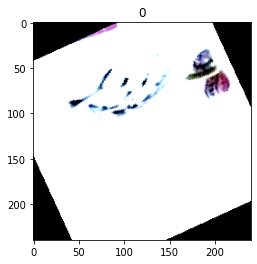

In [8]:
for images, labels in train_loader:
    print(plt.imshow(images[0].permute(1,2,0)))
    plt.title(labels[0].item())
    break

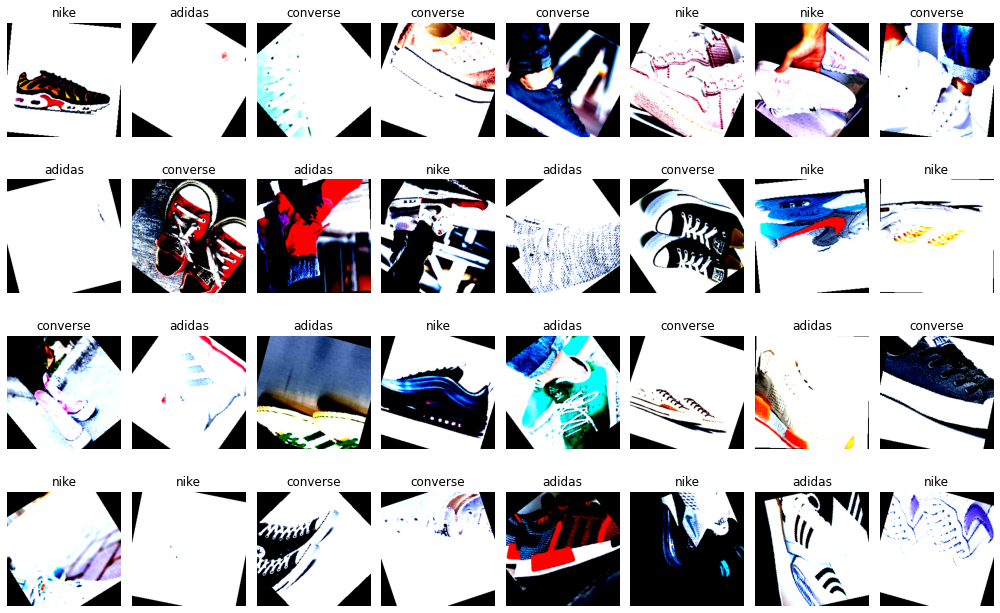

In [9]:
batch = next(iter(train_loader))

rows = 4
columns = int(batch_size / rows)
class_dict = {0:'adidas', 1:'converse', 2:'nike'}

plt.figure(figsize = (14, 9))

for pos in range(batch_size):
    plt.subplot(rows, columns, pos+1)
    plt.imshow(batch[0][pos].permute(1,2,0))
    plt.title(class_dict[batch[1][pos].item()])
    plt.axis('off')
plt.tight_layout()

Now is the fun part!

It's time to define layers for our Convolutional Nerual Network, here is the list of convolutional layers, activation functions, linear layers used to define the CNN:

[The output image dimensions from every layer are mentioned in square brackets]

Input image dimensions: 3 * 240 * 240

1. Conv2d(3, 64, 3, padding=1): 3 Input layers, applying 64 filters of size 3 * 3 with a padding of 1.
[64 * 240 * 240]
2. ReLU() to normalize the values.
3. MaxPool2d(2, 2): kernel size of 2 * 2 with a stride of 2. 
[64 * 120 * 120]
4. Conv2d(64, 128, 3, padding=1): [128 * 120 * 120]
5. ReLU()
6. MaxPool2d(2, 2): [128 * 60 * 60]
7. Conv2d(128, 512, 3, padding = 1): [512 * 60 * 60]
8. ReLU()
9. MaxPool2d(2, 2): [512 * 30 * 30]

512 layers of size 30 * 30 are then flattened to feed into a Fully Connected Neural Network which has a series of linear layers, activation layers and dropout layers to eventually return 3 linear equation scores per image corresponding to the three classes. 




In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 512, 3, padding = 1),
            nn.ReLU(),            
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2)
        )

        self.fcnn_layers = nn.Sequential(
            nn.Linear(512*30*30, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 3),
        )

    def forward(self, x):
        cnn_logits = self.cnn_layers(x)
        cnn_logits = self.flatten(cnn_logits)
        logits = self.fcnn_layers(cnn_logits)

        return logits

To train and test the network, we need a training loop and a testing loop.

The training loop calculates the loss for every image in the batch, calculates the gradients and updates the weights. It also prints the training loss for every 5th batch.

Notice that the images and labels have been moved to cuda for faster calculations.

In [11]:
def train_loop(dataloader, model, optimizer, criterion):
  model.train()
  
  for batch, (images, labels) in enumerate(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_size = len(images)

    if (batch%5==0):
      print(f'Training loss: {loss: 7f}     [{batch * 32} / {len(dataloader.dataset)}]')

The testing loop predicts the labels of the images in the test set, calculates the loss and accuracy for every batch and then prints the overall accuracy and average test loss for the entire test set.

In [12]:
def test_loop(dataloader, model, criterion):
  model.eval()
  test_loss = 0
  batches = len(dataloader)
  accuracy = 0

  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      logits = model(images)
      test_loss += criterion(logits, labels)
      accuracy += (logits.argmax(dim = 1) == labels).type(torch.float).sum().item()

  accuracy = accuracy / len(dataloader.dataset)
  
  print(f'Average Test Loss: {test_loss / batches: 7f}       Accuracy: {accuracy*100: .2f}%\n')

After defining the learning rate for Adam optimizer and the criterion, let's train the network and evaluate its performance by running the train loop and test loop for 10 epochs.

In [13]:
epochs = 10

model = Net()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model.cuda()
criterion = criterion.to(device)


for epoch in range(epochs):
#   torch.cuda.empty_cache()
  print(f'-----------------epoch-{epoch+1}-----------------')
  train_loop(train_loader, model, optimizer, criterion)
  test_loop(test_loader, model, criterion)

-----------------epoch-1-----------------
Training loss:  1.108001     [0 / 711]
Training loss:  1.335798     [160 / 711]
Training loss:  1.060186     [320 / 711]
Training loss:  1.133767     [480 / 711]
Training loss:  1.156324     [640 / 711]
Average Test Loss:  1.092960       Accuracy:  33.33%

-----------------epoch-2-----------------
Training loss:  1.098020     [0 / 711]
Training loss:  1.099042     [160 / 711]
Training loss:  1.090412     [320 / 711]
Training loss:  1.092958     [480 / 711]
Training loss:  1.112502     [640 / 711]
Average Test Loss:  1.082303       Accuracy:  33.33%

-----------------epoch-3-----------------
Training loss:  1.120943     [0 / 711]
Training loss:  1.126423     [160 / 711]
Training loss:  1.077737     [320 / 711]
Training loss:  1.097141     [480 / 711]
Training loss:  1.097261     [640 / 711]
Average Test Loss:  1.083370       Accuracy:  32.46%

-----------------epoch-4-----------------
Training loss:  1.076971     [0 / 711]
Training loss:  1.0659

The maximum accuracy that could be achieved for the defined network with these specific hyperparameters was 43%, which is not very convincing. It is left to the reader to experiment with different network architectures and sets of hyperparameters to find the ideal model for this task of image classification.

**Transfer Learning:**

Transfer Learning is a technique of using the knowledge gained while solving one problem to solve a different but similar kind of problem.

In this case of Shoe Classification, our goal is to use a pretrained model just for feature selection and then use only these important features as inputs to a fully connected layer and eventually classify into the three classes.


The pretrained model that's used in this project is densenet121. Read more about densenet121 here https://iq.opengenus.org/architecture-of-densenet121/

The densenet model has 2 parts. 
1. Series of Convolutional Layers.
2. A Classification Layer.

Since the series of convolutional layers extract all the important features from the input image, we can simply turn off the gradients of these layers to use the already obtained optimal values. 

The classification layer in densenet121 was built for classifying 10 classes. So, this classification layer has to be rebuilt to classify only 3 classes to solve this Shoe Classification task. After overwriting the pre-built classification layer in densenet121 with our custom defined classification layer, which is nothing but a series of linear, activation and dropout layers, only this classification layer needs to be trained as seen below:



In [14]:
densenet_model = models.densenet121(pretrained = True)

for parameters in densenet_model.parameters():
  parameters.requires_grad = False

classifier = nn.Sequential(
              nn.Linear(1024, 512),
              nn.ReLU(),
              nn.Dropout(p=0.2),
              nn.Linear(512, 128),
              nn.ReLU(),
              nn.Dropout(p=0.2),
              nn.Linear(128, 32),
              nn.ReLU(),
              nn.Dropout(p=0.2),
              nn.Linear(32, 3)
)

densenet_model.classifier = classifier

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

After selecting the apporpriate learning rate and optimizer, let's finally train and validate the densenet model to see the improvement from the previous model!

In [15]:
epochs = 30

learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet_model.classifier.parameters(), lr = learning_rate)

densenet_model.cuda()
criterion.cuda()

for epoch in range(epochs):
  print(f'-------------epoch-{epoch+1}--------------')
  train_loop(train_loader, densenet_model, optimizer, criterion)
  test_loop(test_loader, densenet_model, criterion)

-------------epoch-1--------------
Training loss:  1.113768     [0 / 711]
Training loss:  1.096822     [160 / 711]
Training loss:  1.094926     [320 / 711]
Training loss:  1.109951     [480 / 711]
Training loss:  1.081225     [640 / 711]
Average Test Loss:  1.094415       Accuracy:  33.33%

-------------epoch-2--------------
Training loss:  1.082407     [0 / 711]
Training loss:  1.093760     [160 / 711]
Training loss:  1.096160     [320 / 711]
Training loss:  1.099672     [480 / 711]
Training loss:  1.078469     [640 / 711]
Average Test Loss:  1.082469       Accuracy:  43.86%

-------------epoch-3--------------
Training loss:  1.090444     [0 / 711]
Training loss:  1.100190     [160 / 711]
Training loss:  1.094665     [320 / 711]
Training loss:  1.091125     [480 / 711]
Training loss:  1.093569     [640 / 711]
Average Test Loss:  1.063675       Accuracy:  53.51%

-------------epoch-4--------------
Training loss:  1.093379     [0 / 711]
Training loss:  1.071441     [160 / 711]
Training 

76% accuracy is not too bad, but there is definitely plenty of room for improvement. This was my first project on CNNs and image processing and any feedback is welcome.

Thanks for reading!